# What are the effects of aligning and PBC correction on an `*.xtc` file?

Here is a movie of the input file `./first_1000.xtc`, shown with the periodic box.  I've colored the ligand yellow, and the pocket atoms red-to-blue so we can easily discern each atom.

<img src='before.gif'>

Let's load this trajectory into memory and inspect its *xyz* coordinates

In [1]:
import mdtraj as md
before = md.load_xtc('./first_1000.xtc', top='./new_test.pdb')

/Users/suvince/anaconda2/lib/python2.7/site-packages/numpy/linalg/linalg.py:1821: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/suvince/anaconda2/lib/python2.7/site-packages/mdtraj/formats/pdb/pdbfile.py:194: RuntimeWarning: divide by zero encountered in true_divide
  particle_density = traj.top.n_atoms / traj.unitcell_volumes[0]
/Users/suvince/anaconda2/lib/python2.7/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


This error is interesting, because it might suggest that mdtraj does not like my idea of having coordinates that go from (about) -1.5 to 1.5 in each direction (as specified by the template PDB)...

Instead, lets try to load this in using the `protein.gro` template:

In [2]:
% ls

#protein.pdb.1#      first_1000.xtc       xy.png
#protein.pdb.2#      new_test.pdb         xz.png
README.md            prod_fah.mdp         yz.png
align_and_pbc.ipynb  protein.gro
before.gif           protein.pdb


In [3]:
!gmx editconf -f protein.gro -o protein.pdb

GROMACS:    gmx editconf, VERSION 5.0.4

GROMACS is written by:
Emile Apol         Rossen Apostolov   Herman J.C. Berendsen Par Bjelkmar       
Aldert van Buuren  Rudi van Drunen    Anton Feenstra     Sebastian Fritsch  
Gerrit Groenhof    Christoph Junghans Peter Kasson       Carsten Kutzner    
Per Larsson        Justin A. Lemkul   Magnus Lundborg    Pieter Meulenhoff  
Erik Marklund      Teemu Murtola      Szilard Pall       Sander Pronk       
Roland Schulz      Alexey Shvetsov    Michael Shirts     Alfons Sijbers     
Peter Tieleman     Christian Wennberg Maarten Wolf       
and the project leaders:
Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2014, The GROMACS development team at
Uppsala University, Stockholm University and
the Royal Institute of Technology, Sweden.
check out http://www.gromacs.org for more information.

GROMACS is free software; you can redistribute it and/or

In [4]:
!cat protein.pdb

TITLE     Pocket in Water in water
REMARK    THIS IS A SIMULATION BOX
CRYST1   30.086   30.086   30.086  90.00  90.00  90.00 P 1           1
MODEL        1
ATOM      1  C1  DUM     1      15.290  27.760  20.990  1.00  0.00            
ATOM      2  C2  DUM     1      18.720  26.240  22.530  1.00  0.00            
ATOM      3  C3  DUM     1      13.050  29.320  27.020  1.00  0.00            
ATOM      4  C4  DUM     1      16.640  28.100  28.320  1.00  0.00            
ATOM      5  C5  DUM     1      12.390  27.160  23.700  1.00  0.00            
ATOM      6  C6  DUM     1      14.120   0.710  23.420  1.00  0.00            
ATOM      7  C7  DUM     1      17.890  24.890  26.250  1.00  0.00            
ATOM      8  C8  DUM     1      19.710  28.440  25.740  1.00  0.00            
ATOM      9  C9  DUM     1      15.220  24.440  23.260  1.00  0.00            
ATOM     10  C10 DUM     1      18.020   0.150  22.560  1.00  0.00            
ATOM     11  C11 DUM     1      14.000  25.450  26.960

As we can see, GROMACS likes to make all the coordinates positiive with the origin (0,0,0) in the corner.

Now let's use `protein.pdb` as our template, and inspect the coordinates:

In [5]:
before = md.load_xtc('./first_1000.xtc', top='./protein.pdb')
print '(nframes, natoms, dof) =', before.xyz.shape

# Print the 500th frame
print 'before.xyz[500,:,:]', before.xyz[500,:,:]

(nframes, natoms, dof) = (1000, 12, 3)
before.xyz[500,:,:] [[ 1.9000001   2.4000001   2.60000014]
 [ 1.60000002  2.5         2.5       ]
 [ 2.10000014  3.00000024  2.60000014]
 [ 1.80000007  0.1         2.4000001 ]
 [ 2.20000005  2.60000014  2.5       ]
 [ 2.10000014  2.70000005  2.80000019]
 [ 1.60000002  2.80000019  2.20000005]
 [ 1.50000012  2.9000001   2.60000014]
 [ 1.9000001   2.5         2.20000005]
 [ 1.70000005  2.60000014  2.80000019]
 [ 2.          2.9000001   2.20000005]
 [ 1.20000005  2.30000019  2.60000014]]


## Uh-oh!   This is very disturbing -- all the coordinates are rounded off to the nearest Angstrom?

Let's make a plot of just the *x* vs *y* coordinates of the first atom, and see if there are roundoff errors....

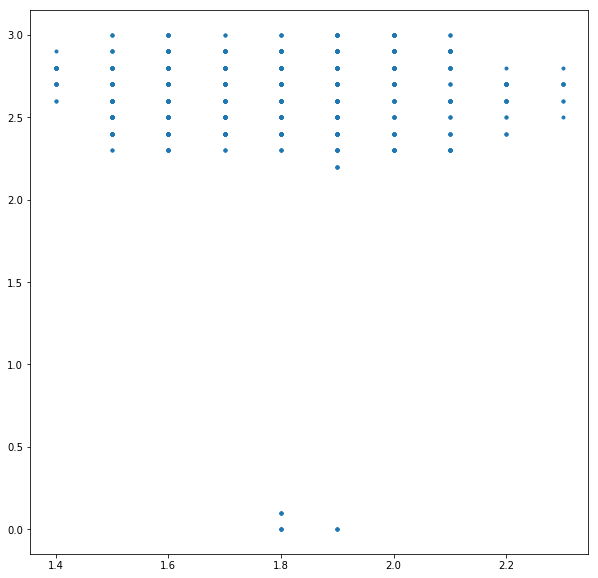

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure( figsize=(10,10))
plt.plot(before.xyz[:,0,0],before.xyz[:,0,1],'.')

## YUP. :(  Looks like there is a round-off discretization error!!!!

This explains why Yunhui observed some of the coordinates to have *exactly* the same values.  They are essentially discretized in increments of 0.1 nm.

### Some reasons for this *might* be:

* limited precision in the original trajectory, i.e. an `*.mdp` setting?
* loss of precision when transforming from VMD, etc?  Yunhui, how did you make the `./first_1000.xtc` file? 

We can verify that this problem is *not* `mdtraj`, by using `gmxdump` to print the coordinates saved in `./first_1000.xtc`:

In [7]:
!gmx dump -f ./first_1000.xtc

GROMACS:    gmx dump, VERSION 5.0.4

GROMACS is written by:
Emile Apol         Rossen Apostolov   Herman J.C. Berendsen Par Bjelkmar       
Aldert van Buuren  Rudi van Drunen    Anton Feenstra     Sebastian Fritsch  
Gerrit Groenhof    Christoph Junghans Peter Kasson       Carsten Kutzner    
Per Larsson        Justin A. Lemkul   Magnus Lundborg    Pieter Meulenhoff  
Erik Marklund      Teemu Murtola      Szilard Pall       Sander Pronk       
Roland Schulz      Alexey Shvetsov    Michael Shirts     Alfons Sijbers     
Peter Tieleman     Christian Wennberg Maarten Wolf       
and the project leaders:
Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2014, The GROMACS development team at
Uppsala University, Stockholm University and
the Royal Institute of Technology, Sweden.
check out http://www.gromacs.org for more information.

GROMACS is free software; you can redistribute it and/or mod

      x[    6]={ 1.50000e+00,  2.70000e+00,  2.70000e+00}
      x[    7]={ 1.80000e+00,  2.40000e+00,  2.70000e+00}
      x[    8]={ 1.40000e+00,  2.80000e+00,  2.30000e+00}
      x[    9]={ 1.80000e+00,  2.30000e+00,  2.30000e+00}
      x[   10]={ 1.70000e+00,  0.00000e+00,  2.50000e+00}
      x[   11]={ 2.30000e+00,  1.60000e+00,  2.80000e+00}
./first_1000.xtc frame 127:
   natoms=        12  step=       127  time=1.2700000e+02  prec=      1000
   box (3x3):
      box[    0]={ 3.00859e+00,  0.00000e+00,  0.00000e+00}
      box[    1]={ 0.00000e+00,  3.00859e+00,  0.00000e+00}
      box[    2]={ 0.00000e+00,  0.00000e+00,  3.00859e+00}
   x (12x3):
      x[    0]={ 1.60000e+00,  2.50000e+00,  2.00000e+00}
      x[    1]={ 1.50000e+00,  2.40000e+00,  2.40000e+00}
      x[    2]={ 2.10000e+00,  2.90000e+00,  2.40000e+00}
      x[    3]={ 1.90000e+00,  2.80000e+00,  2.70000e+00}
      x[    4]={ 1.80000e+00,  2.90000e+00,  2.10000e+00}
      x[    5]={ 2.00000e+00,  2.60000e+00,  2.10000

      x[    2]={ 2.10000e+00,  2.40000e+00,  2.20000e+00}
      x[    3]={ 2.20000e+00,  2.70000e+00,  2.30000e+00}
      x[    4]={ 1.70000e+00,  2.50000e+00,  2.10000e+00}
      x[    5]={ 1.80000e+00,  2.20000e+00,  2.40000e+00}
      x[    6]={ 1.90000e+00,  3.00000e+00,  2.40000e+00}
      x[    7]={ 2.00000e+00,  2.80000e+00,  2.70000e+00}
      x[    8]={ 1.60000e+00,  2.80000e+00,  2.20000e+00}
      x[    9]={ 1.70000e+00,  2.50000e+00,  2.70000e+00}
      x[   10]={ 2.00000e+00,  2.70000e+00,  2.00000e+00}
      x[   11]={ 2.10000e+00,  2.40000e+00,  2.50000e+00}
./first_1000.xtc frame 389:
   natoms=        12  step=       389  time=3.8900000e+02  prec=      1000
   box (3x3):
      box[    0]={ 3.00859e+00,  0.00000e+00,  0.00000e+00}
      box[    1]={ 0.00000e+00,  3.00859e+00,  0.00000e+00}
      box[    2]={ 0.00000e+00,  0.00000e+00,  3.00859e+00}
   x (12x3):
      x[    0]={ 1.50000e+00,  2.50000e+00,  2.40000e+00}
      x[    1]={ 1.60000e+00,  2.80000e+00,  2.60000

      box[    1]={ 0.00000e+00,  3.00859e+00,  0.00000e+00}
      box[    2]={ 0.00000e+00,  0.00000e+00,  3.00859e+00}
   x (12x3):
      x[    0]={ 1.90000e+00,  2.40000e+00,  2.30000e+00}
      x[    1]={ 2.20000e+00,  2.50000e+00,  2.60000e+00}
      x[    2]={ 1.60000e+00,  3.00000e+00,  2.50000e+00}
      x[    3]={ 1.90000e+00,  0.00000e+00,  2.70000e+00}
      x[    4]={ 1.60000e+00,  2.60000e+00,  2.40000e+00}
      x[    5]={ 1.80000e+00,  2.80000e+00,  2.20000e+00}
      x[    6]={ 2.00000e+00,  2.70000e+00,  2.90000e+00}
      x[    7]={ 2.20000e+00,  2.90000e+00,  2.60000e+00}
      x[    8]={ 1.80000e+00,  2.40000e+00,  2.70000e+00}
      x[    9]={ 2.20000e+00,  2.70000e+00,  2.20000e+00}
      x[   10]={ 1.60000e+00,  2.70000e+00,  2.80000e+00}
      x[   11]={ 1.30000e+00,  2.40000e+00,  2.60000e+00}
./first_1000.xtc frame 637:
   natoms=        12  step=       637  time=6.3700000e+02  prec=      1000
   box (3x3):
      box[    0]={ 3.00859e+00,  0.00000e+00,  0.00000

./first_1000.xtc frame 805:
   natoms=        12  step=       805  time=8.0500000e+02  prec=      1000
   box (3x3):
      box[    0]={ 3.00859e+00,  0.00000e+00,  0.00000e+00}
      box[    1]={ 0.00000e+00,  3.00859e+00,  0.00000e+00}
      box[    2]={ 0.00000e+00,  0.00000e+00,  3.00859e+00}
   x (12x3):
      x[    0]={ 1.90000e+00,  2.70000e+00,  2.30000e+00}
      x[    1]={ 1.60000e+00,  2.70000e+00,  2.40000e+00}
      x[    2]={ 2.10000e+00,  2.80000e+00,  3.00000e+00}
      x[    3]={ 1.70000e+00,  2.80000e+00,  1.00000e-01}
      x[    4]={ 2.10000e+00,  3.00000e+00,  2.60000e+00}
      x[    5]={ 2.20000e+00,  2.60000e+00,  2.60000e+00}
      x[    6]={ 1.50000e+00,  2.90000e+00,  2.80000e+00}
      x[    7]={ 1.50000e+00,  2.50000e+00,  2.80000e+00}
      x[    8]={ 1.70000e+00,  0.00000e+00,  2.50000e+00}
      x[    9]={ 1.80000e+00,  2.40000e+00,  2.50000e+00}
      x[   10]={ 1.80000e+00,  1.00000e-01,  2.90000e+00}
      x[   11]={ 1.60000e+00,  1.20000e+00,  2.30000

      x[   10]={ 2.00000e+00,  2.90000e+00,  2.50000e+00}
      x[   11]={ 1.00000e-01,  5.00000e-01,  1.50000e+00}
./first_1000.xtc frame 931:
   natoms=        12  step=       931  time=9.3100000e+02  prec=      1000
   box (3x3):
      box[    0]={ 3.00859e+00,  0.00000e+00,  0.00000e+00}
      box[    1]={ 0.00000e+00,  3.00859e+00,  0.00000e+00}
      box[    2]={ 0.00000e+00,  0.00000e+00,  3.00859e+00}
   x (12x3):
      x[    0]={ 1.60000e+00,  2.30000e+00,  2.60000e+00}
      x[    1]={ 1.50000e+00,  2.60000e+00,  2.30000e+00}
      x[    2]={ 1.80000e+00,  2.90000e+00,  2.90000e+00}
      x[    3]={ 1.60000e+00,  1.00000e-01,  2.60000e+00}
      x[    4]={ 2.00000e+00,  2.60000e+00,  2.70000e+00}
      x[    5]={ 1.60000e+00,  2.50000e+00,  2.90000e+00}
      x[    6]={ 1.70000e+00,  2.90000e+00,  2.30000e+00}
      x[    7]={ 1.30000e+00,  2.90000e+00,  2.50000e+00}
      x[    8]={ 1.90000e+00,  2.60000e+00,  2.40000e+00}
      x[    9]={ 1.30000e+00,  2.50000e+00,  2.70000

In [10]:
before.unitcell_lengths

array([[ 3.00858998,  3.00858998,  3.00858998],
       [ 3.00858998,  3.00858998,  3.00858998],
       [ 3.00858998,  3.00858998,  3.00858998],
       ..., 
       [ 3.00858998,  3.00858998,  3.00858998],
       [ 3.00858998,  3.00858998,  3.00858998],
       [ 3.00858998,  3.00858998,  3.00858998]], dtype=float32)